In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
print(tf.__version__)

2.12.0


In [4]:
tf.random.set_seed(42)
np.random.seed(42)

In [5]:
train_df = pd.read_csv('data/train.csv').drop('Date',axis=1)
val_df = pd.read_csv('data/val.csv').drop('Date',axis=1)
test_df = pd.read_csv('data/test.csv').drop('Date',axis=1)

print(train_df.shape, val_df.shape, test_df.shape)

(352, 15) (100, 15) (24, 15)


## `DataWindow` class 

In [6]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='Adj Close', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [7]:
def compile_and_fit(model, window, patience=3, max_epochs=1000):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [8]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## Baseline models 

In [9]:
multi_window = DataWindow(input_width=7, label_width=7, shift=7, label_columns=['Adj Close'])

### Repeat last value 

In [10]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 7, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 7, 1])

In [11]:
baseline_last = MultiStepLastBaseline(label_index=column_indices['Adj Close'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(multi_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(multi_window.test, verbose=0)

3/3 [==============================] - 0s 6ms/step - loss: 0.0868 - mean_absolute_error: 0.2041


### Repeat last day 

In [12]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [13]:
baseline_repeat = RepeatBaseline(label_index=column_indices['Adj Close'])

baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.val)
performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.test, verbose=0)

3/3 [==============================] - 0s 3ms/step - loss: 0.0878 - mean_absolute_error: 0.2083


## Linear model 

In [14]:
label_index = column_indices['Adj Close']
num_features = train_df.shape[1]

linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(linear, multi_window)

val_performance['Linear'] = linear.evaluate(multi_window.val)
performance['Linear'] = linear.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
11/11 [==============================] - 1s 18ms/step - loss: 0.2830 - mean_absolute_error: 0.4967 - val_loss: 0.0235 - val_mean_absolute_error: 0.1404
Epoch 2/1000
11/11 [==============================] - 0s 9ms/step - loss: 0.1922 - mean_absolute_error: 0.4049 - val_loss: 0.0122 - val_mean_absolute_error: 0.0995
Epoch 3/1000
11/11 [==============================] - 0s 9ms/step - loss: 0.1248 - mean_absolute_error: 0.3191 - val_loss: 0.0055 - val_mean_absolute_error: 0.0633
Epoch 4/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0759 - mean_absolute_error: 0.2429 - val_loss: 0.0026 - val_mean_absolute_error: 0.0426
Epoch 5/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0453 - mean_absolute_error: 0.1796 - val_loss: 0.0023 - val_mean_absolute_error: 0.0389
Epoch 6/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0276 - mean_absolute_error: 0.1330 - val_loss: 0.0035 - val_mean_absolute_error: 0.0484
Epoch 7/1000
11

## Dense model 

In [15]:
dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(dense, multi_window)

val_performance['Dense'] = dense.evaluate(multi_window.val)
performance['Dense'] = dense.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
11/11 [==============================] - 1s 24ms/step - loss: 0.2765 - mean_absolute_error: 0.4895 - val_loss: 0.0137 - val_mean_absolute_error: 0.1082
Epoch 2/1000
11/11 [==============================] - 0s 9ms/step - loss: 0.0940 - mean_absolute_error: 0.2590 - val_loss: 0.0197 - val_mean_absolute_error: 0.1309
Epoch 3/1000
11/11 [==============================] - 0s 9ms/step - loss: 0.0283 - mean_absolute_error: 0.1426 - val_loss: 0.0315 - val_mean_absolute_error: 0.1706
Epoch 4/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0143 - mean_absolute_error: 0.0945 - val_loss: 0.0112 - val_mean_absolute_error: 0.0935
Epoch 5/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0139 - mean_absolute_error: 0.0905 - val_loss: 0.0196 - val_mean_absolute_error: 0.1319
Epoch 6/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0119 - mean_absolute_error: 0.0870 - val_loss: 0.0181 - val_mean_absolute_error: 0.1262
Epoch 7/1000
3/

## LSTM model 

In [16]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(lstm_model, multi_window)

val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
11/11 [==============================] - 3s 84ms/step - loss: 0.2995 - mean_absolute_error: 0.5116 - val_loss: 0.0277 - val_mean_absolute_error: 0.1521
Epoch 2/1000
11/11 [==============================] - 0s 14ms/step - loss: 0.1929 - mean_absolute_error: 0.3981 - val_loss: 0.0100 - val_mean_absolute_error: 0.0812
Epoch 3/1000
11/11 [==============================] - 0s 14ms/step - loss: 0.0772 - mean_absolute_error: 0.2226 - val_loss: 0.0325 - val_mean_absolute_error: 0.1393
Epoch 4/1000
11/11 [==============================] - 0s 9ms/step - loss: 0.0617 - mean_absolute_error: 0.2035 - val_loss: 0.0394 - val_mean_absolute_error: 0.1540
Epoch 5/1000
3/3 [==============================] - 0s 3ms/step - loss: 0.0193 - mean_absolute_error: 0.1113


## CNN model 

In [17]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 7
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

cnn_multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=7, label_columns=['Adj Close'])

In [18]:
cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_model, cnn_multi_window)

val_performance['CNN'] = cnn_model.evaluate(cnn_multi_window.val)
performance['CNN'] = cnn_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/1000
11/11 [==============================] - 2s 39ms/step - loss: 0.2918 - mean_absolute_error: 0.5044 - val_loss: 0.0217 - val_mean_absolute_error: 0.1358
Epoch 2/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.1349 - mean_absolute_error: 0.3292 - val_loss: 0.0027 - val_mean_absolute_error: 0.0412
Epoch 3/1000
11/11 [==============================] - 0s 9ms/step - loss: 0.0253 - mean_absolute_error: 0.1309 - val_loss: 0.0233 - val_mean_absolute_error: 0.1426
Epoch 4/1000
11/11 [==============================] - 0s 8ms/step - loss: 0.0175 - mean_absolute_error: 0.1065 - val_loss: 0.0049 - val_mean_absolute_error: 0.0570
Epoch 5/1000
3/3 [==============================] - 0s 6ms/step - loss: 0.0057 - mean_absolute_error: 0.0615


## CNN + LSTM model 

In [19]:
cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_lstm_model, cnn_multi_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/1000
11/11 [==============================] - 3s 57ms/step - loss: 0.2954 - mean_absolute_error: 0.5079 - val_loss: 0.0238 - val_mean_absolute_error: 0.1403
Epoch 2/1000
11/11 [==============================] - 0s 12ms/step - loss: 0.1554 - mean_absolute_error: 0.3456 - val_loss: 0.0111 - val_mean_absolute_error: 0.0885
Epoch 3/1000
11/11 [==============================] - 0s 12ms/step - loss: 0.0520 - mean_absolute_error: 0.1832 - val_loss: 0.0783 - val_mean_absolute_error: 0.2375
Epoch 4/1000
11/11 [==============================] - 0s 11ms/step - loss: 0.0479 - mean_absolute_error: 0.1804 - val_loss: 0.0424 - val_mean_absolute_error: 0.1765
Epoch 5/1000
3/3 [==============================] - 0s 6ms/step - loss: 0.0285 - mean_absolute_error: 0.1449


## Autoregressive LSTM 

In [20]:
class AutoRegressive(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(train_df.shape[1])
        
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
                
        return prediction, state
    
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        
        predictions.append(prediction)
        
        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            
            prediction = self.dense(x)
            predictions.append(prediction)
        
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        
        return predictions

In [21]:
AR_LSTM = AutoRegressive(units=32, out_steps=7)

history = compile_and_fit(AR_LSTM, multi_window)

val_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.val)
performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
11/11 [==============================] - 4s 44ms/step - loss: 0.3322 - mean_absolute_error: 0.5299 - val_loss: 0.0344 - val_mean_absolute_error: 0.1502
Epoch 2/1000
11/11 [==============================] - 0s 19ms/step - loss: 0.1793 - mean_absolute_error: 0.3621 - val_loss: 0.0290 - val_mean_absolute_error: 0.1337
Epoch 3/1000
11/11 [==============================] - 0s 11ms/step - loss: 0.0762 - mean_absolute_error: 0.2111 - val_loss: 0.0487 - val_mean_absolute_error: 0.1887
Epoch 4/1000
11/11 [==============================] - 0s 11ms/step - loss: 0.0361 - mean_absolute_error: 0.1493 - val_loss: 0.0365 - val_mean_absolute_error: 0.1621
Epoch 5/1000
11/11 [==============================] - 0s 10ms/step - loss: 0.0226 - mean_absolute_error: 0.1184 - val_loss: 0.0283 - val_mean_absolute_error: 0.1413
Epoch 6/1000
11/11 [==============================] - 0s 11ms/step - loss: 0.0184 - mean_absolute_error: 0.1066 - val_loss: 0.0214 - val_mean_absolute_error: 0.1185
Epoch 7/10

In [22]:
cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_lstm_model, cnn_multi_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/1000
11/11 [==============================] - 2s 41ms/step - loss: 0.3013 - mean_absolute_error: 0.5137 - val_loss: 0.0256 - val_mean_absolute_error: 0.1467
Epoch 2/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.1761 - mean_absolute_error: 0.3739 - val_loss: 0.0092 - val_mean_absolute_error: 0.0811
Epoch 3/1000
11/11 [==============================] - 0s 6ms/step - loss: 0.0563 - mean_absolute_error: 0.1892 - val_loss: 0.0908 - val_mean_absolute_error: 0.2610
Epoch 4/1000
11/11 [==============================] - 0s 7ms/step - loss: 0.0508 - mean_absolute_error: 0.1850 - val_loss: 0.0556 - val_mean_absolute_error: 0.2057
Epoch 5/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.0346 - mean_absolute_error: 0.1623


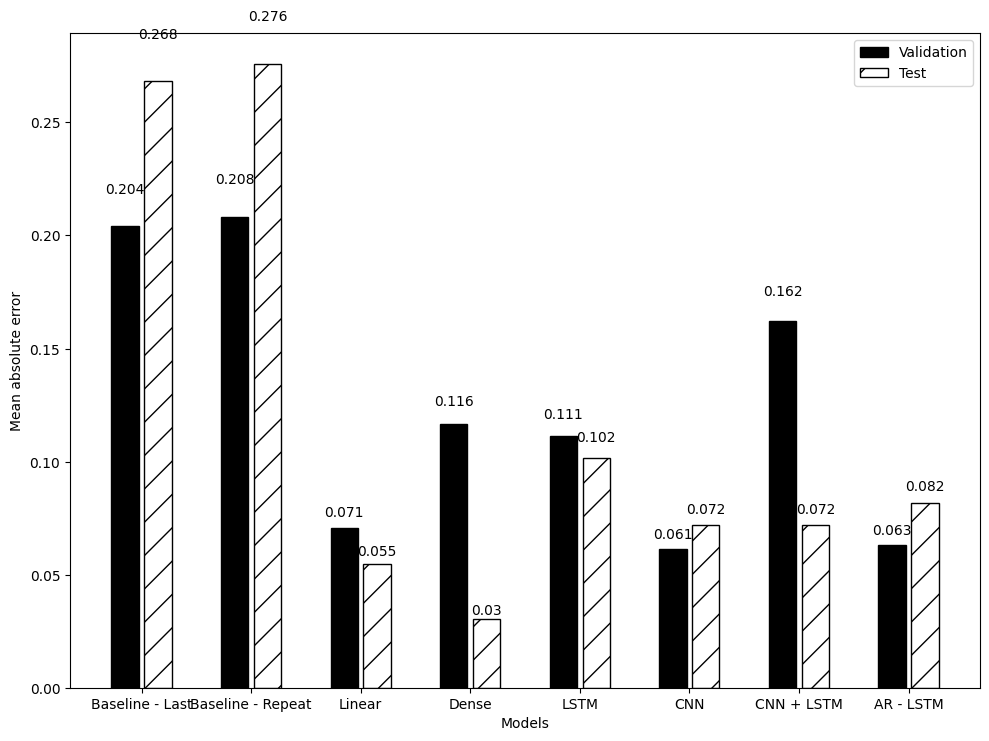

In [23]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+value*0.07, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+value*0.07, s=str(round(value, 3)), ha='center')

# plt.ylim(0, 0.33)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH18_F14_peixeiro.png', dpi=300)